In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import Library
import datetime
import matplotlib
import itertools

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

## <hr><center>Load the datasets cleaned by the Task 1 Notebook</center><hr>

In [ ]:
players_df = pd.read_csv('../data_cleaned/players.csv')
print(f'(players_df) Loading {players_df.shape[0]} rows from "../data_cleaned/players_df.csv"')

matches_df = pd.read_csv('../data_cleaned/matches_side.csv')
print(f'(matches_side_df) Loading {matches_df.shape[0]} rows from "../data_cleaned/matches_side_df.csv"')

players_statistics    = Library.deserialize_statistics('data/players_df.stat')
match_side_statistics = Library.deserialize_statistics('data/match_side_df.stat')

(players_df) Loading 1918 rows from "../data_cleaned/players_df.csv"
(matches_side_df) Loading 370946 rows from "../data_cleaned/matches_side_df.csv"


## <hr><center>Hierarchical Clustering</center><hr>

In [ ]:
# Consider the clustering attributes we searched and selected for the task.
clustering_attributes = ['avg_ace%', 'avg_df%', 'avg_1st%', 'avg_bpSaved%', 'win_rate', 'rank_points']

# Normalize the resulting data using StandardScaler.
scaler = StandardScaler()
numerical_attributes = Library.numerical_attributes(players_statistics)
norm_players_df = pd.DataFrame(scaler.fit_transform(players_df[numerical_attributes]), columns=numerical_attributes)
clustering_players_df = norm_players_df[clustering_attributes]

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from scipy.spatial.distance import pdist, squareform

# Compute the linkage matrix and then obtains the dendrogram.
# The tree cut at the given height is then returned to obtain the clusters.
def hierarchical_clustering_process(df, distances, method, metric, height):
    print(f'Hierarchical {method}')
    plt.gcf().set_size_inches(14, 7)
    # Compute the linkage using the distance matrix, method and metric given.
    data_link = linkage(distances, method=method, metric=metric)
    # Use the height for the threshold.
    dendrogram(data_link, truncate_mode='lastp', color_threshold=height)
    plt.axhline(y=height, color="black")
    plt.gcf().set_size_inches(14, 10)
    Library.save(f'{method}_dendogram.svg')
    plt.show()
    # Use again the height for actually cutting the tree.
    return cut_tree(data_link, height=height)

# Provide the cluster statistics with sizes and boxplots.
def characterize_clusters(df, label, cluster_labels, show_boxplots=True):
    print(df[label].value_counts())
    df[label].value_counts().plot(kind='bar'),  
    plt.gcf().set_size_inches(6, 4)
    Library.save(f'{label}_cluster.svg')  
    plt.show()
    if show_boxplots:
        plt.gcf().set_size_inches(20, 23)
        plt.subplots_adjust(hspace=0.35)   
        Library.plot_clusters(players_statistics, players_df, label)
        Library.save(f'{label}_val.svg')

# Compute the distances between the players using euclidean.
distances = pdist(clustering_players_df, metric='euclidean')

# Main hierachical clustering process.
def hierarchical_process(method, height, show_boxplots=True):
    cluster_labels = hierarchical_clustering_process(df=clustering_players_df, distances=distances, method=method, height=height, metric='euclidean')
    label = method + 'Label'
    players_df[label] = cluster_labels
    Library.reorder_clusters(players_df, label)
    # Reorder the ward labels to provide better comparison with the KMeans classification.
    if method == 'ward':
        Library.swap_indices(players_df, label, 2, 3)
        Library.swap_indices(players_df, label, 0, 2)
        Library.swap_indices(players_df, label, 1, 2)
    characterize_clusters(players_df, cluster_labels=cluster_labels, label=label, show_boxplots=show_boxplots)
    print("Silhoutte =",silhouette_score(norm_players_df[clustering_attributes], players_df[label]))

## Single

Hierarchical single


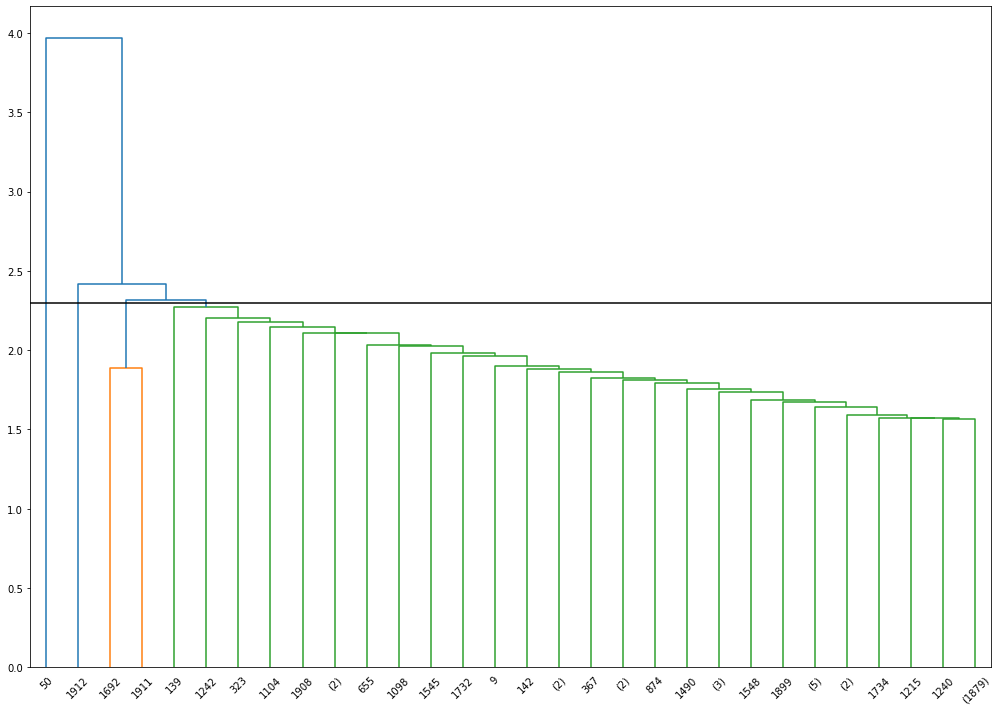

0    1914
1       2
2       1
3       1
Name: singleLabel, dtype: int64


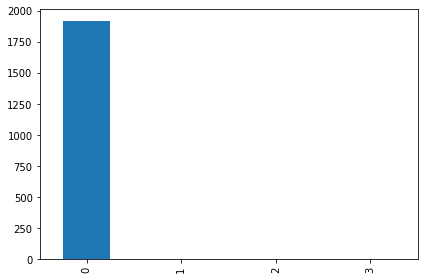

Silhoutte = 0.5627520894063136


In [ ]:
hierarchical_process('single', 2.3, show_boxplots=False)

## Complete

Hierarchical complete


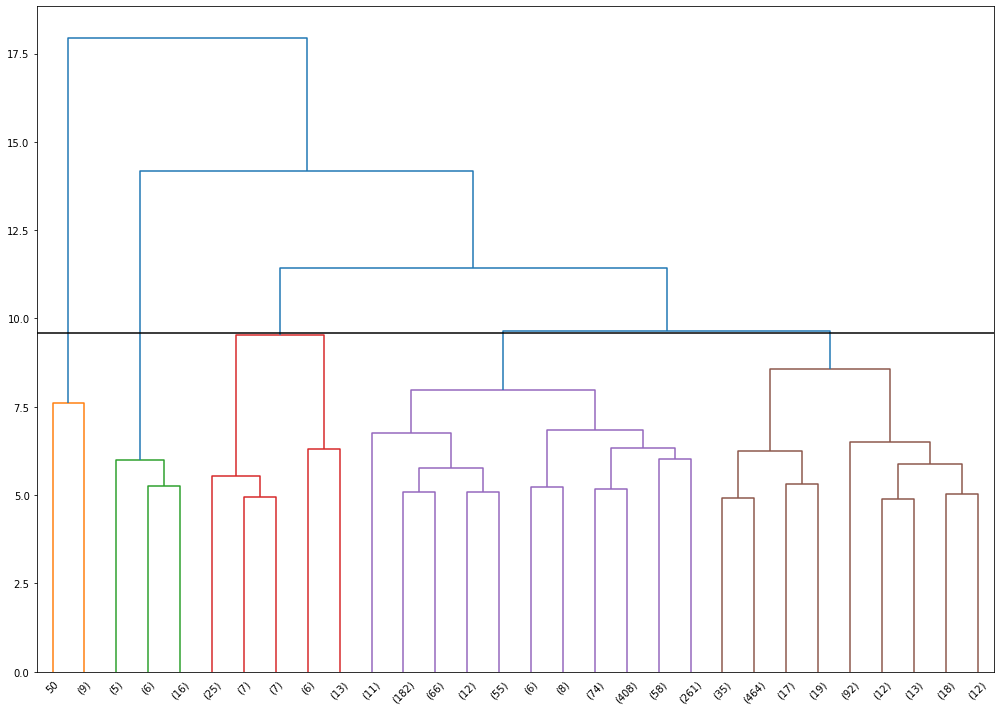

0    1141
1     682
2      58
3      27
4      10
Name: completeLabel, dtype: int64


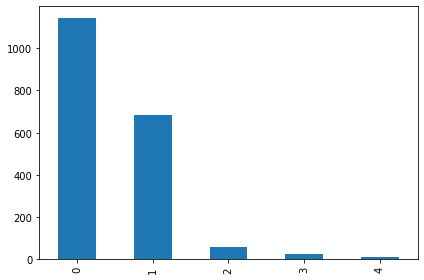

Silhoutte = 0.1415146796278981


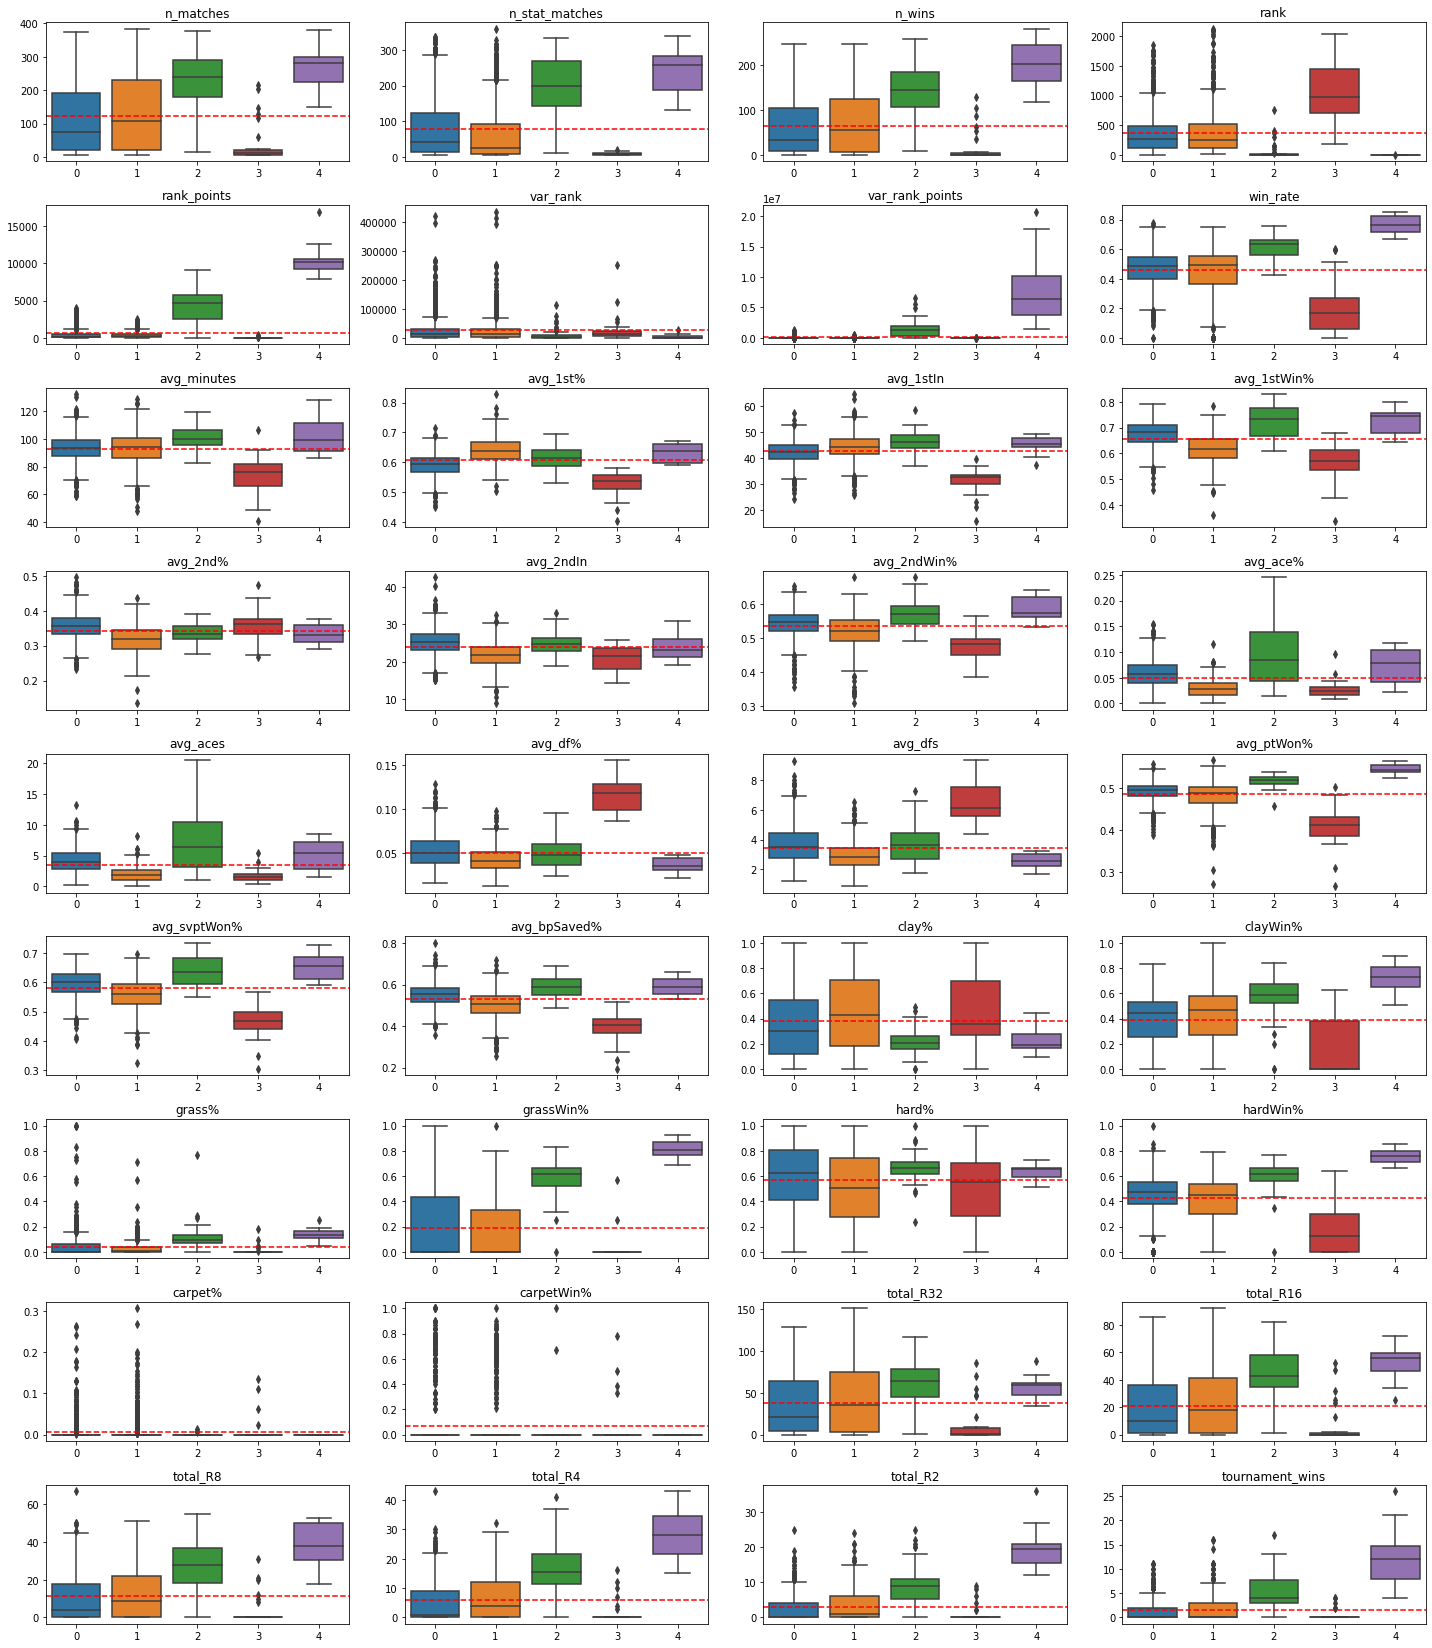

In [ ]:
hierarchical_process('complete', 9.6)

## Average

Hierarchical average


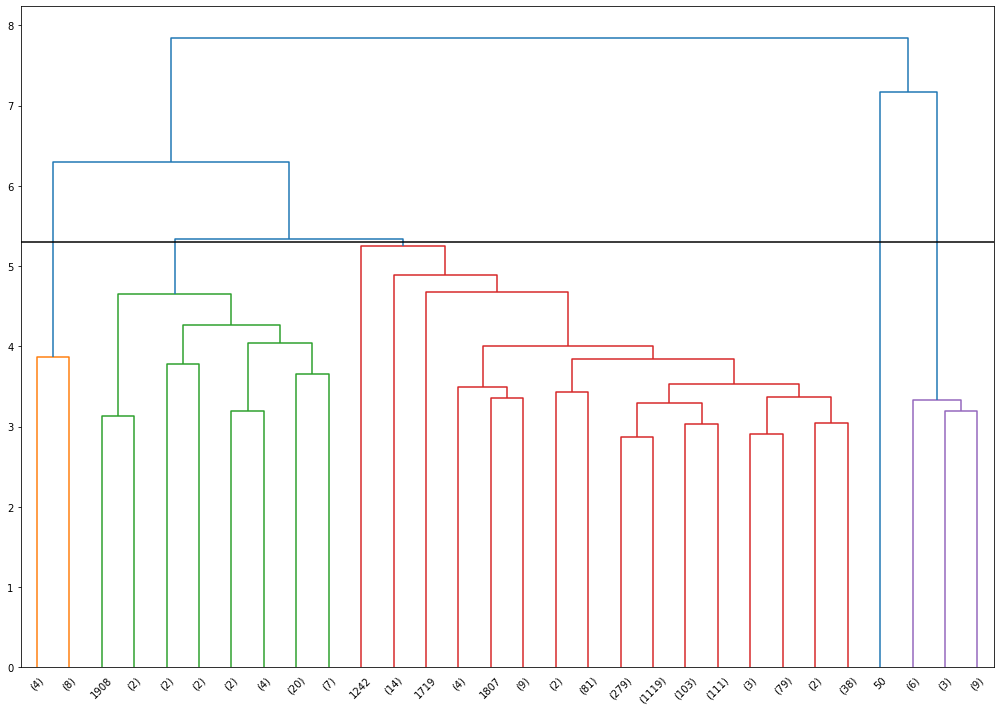

0    1847
1      40
2      18
3      12
4       1
Name: averageLabel, dtype: int64


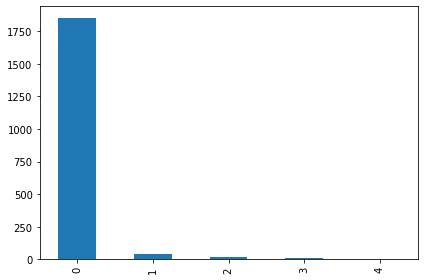

Silhoutte = 0.4044910989222902


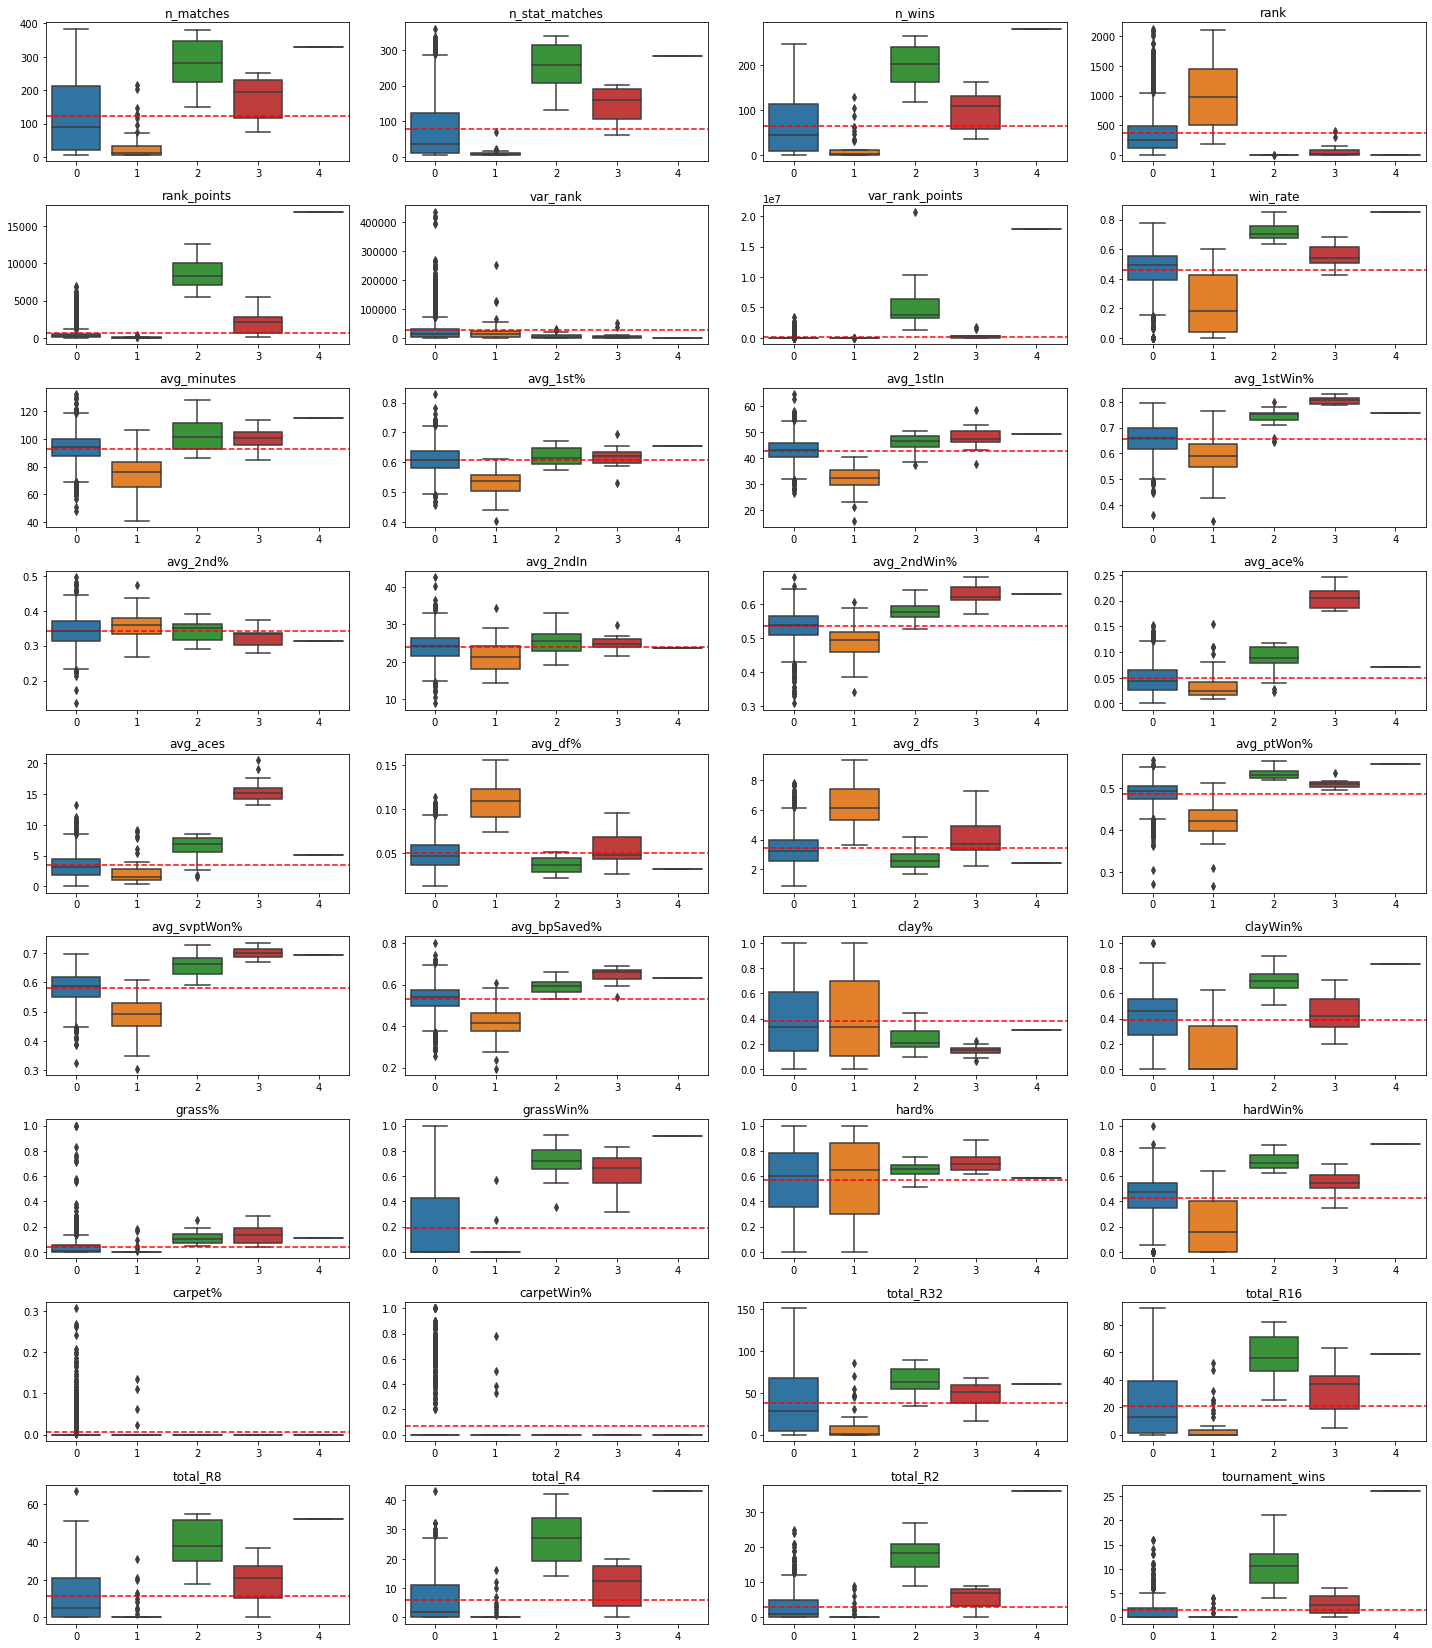

In [ ]:
hierarchical_process('average', 5.3)

## Ward

Hierarchical ward


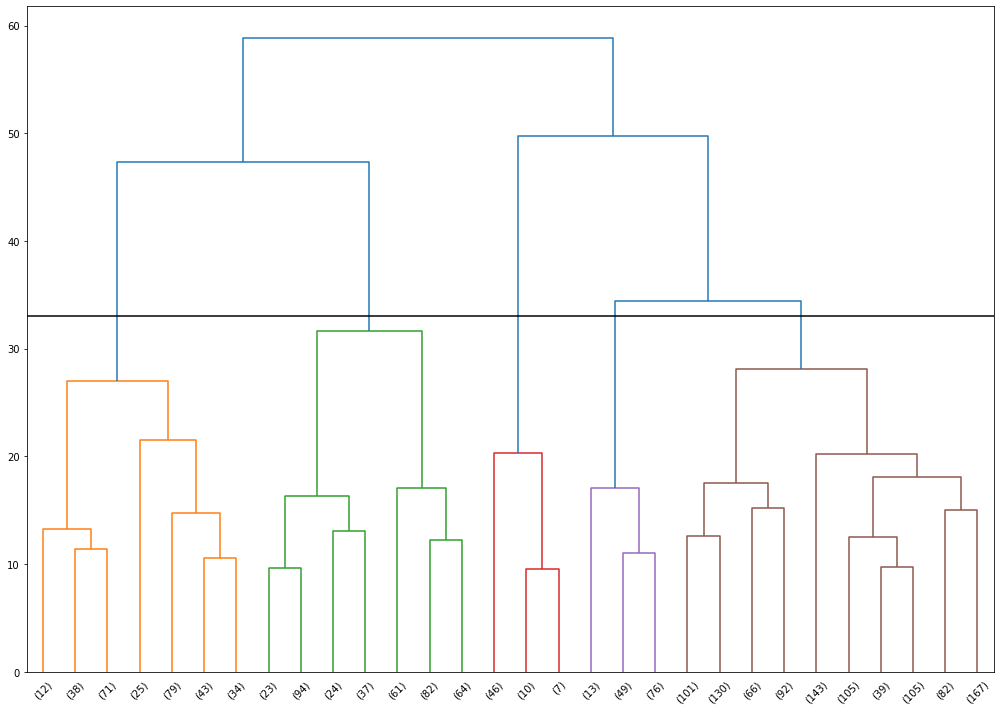

1    1030
2     385
3     302
0     138
4      63
Name: wardLabel, dtype: int64


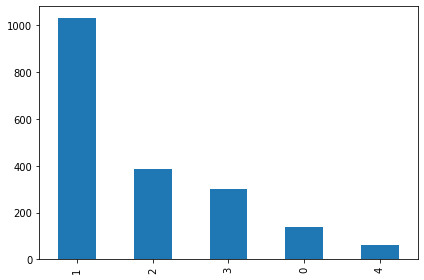

Silhoutte = 0.16222311924461164


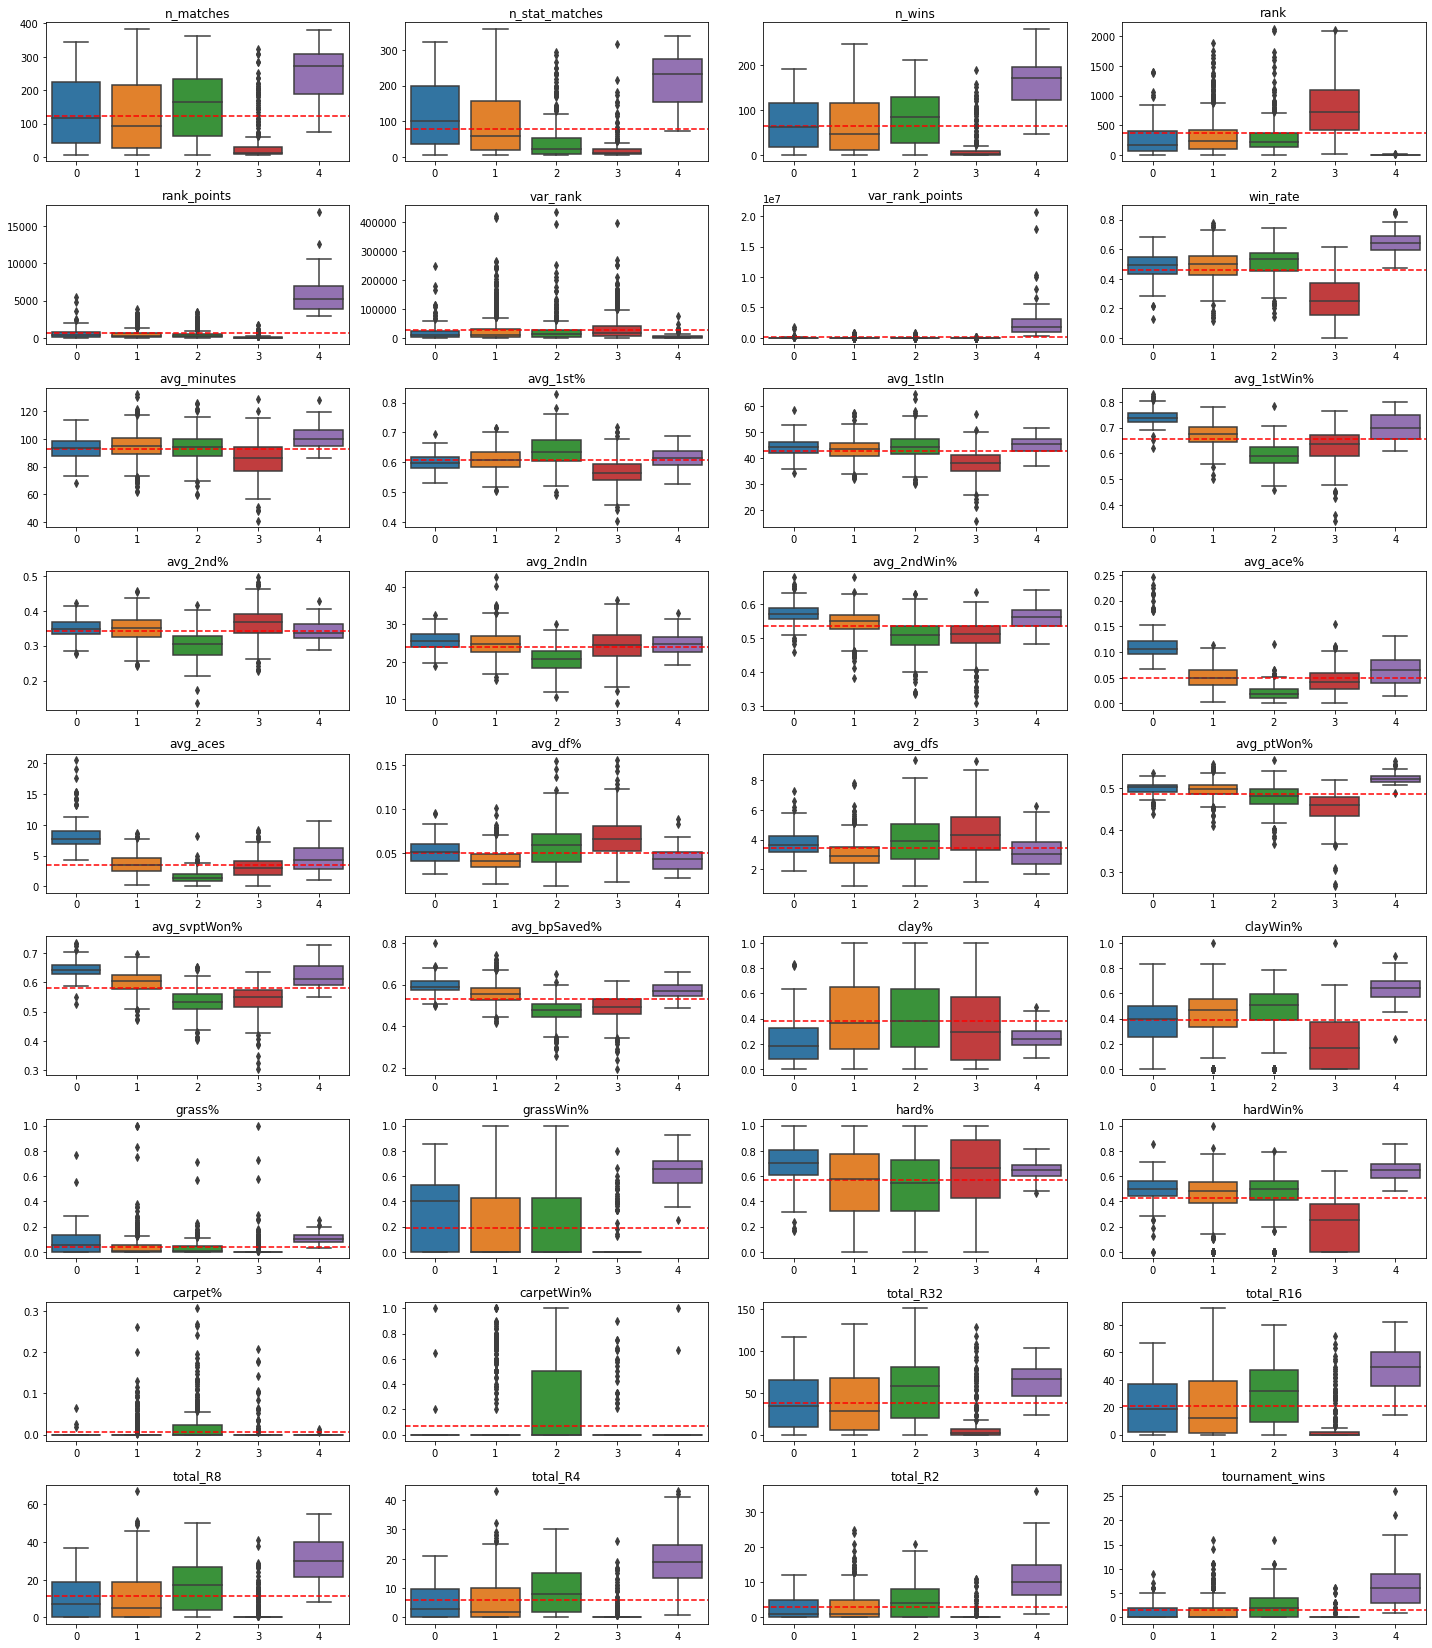

In [ ]:
# 21 -> 8 clusters
# 32 -> 5 clusters
hierarchical_process('ward', 33)